In [9]:
import notebooks._init_paths


In [10]:
# Add project root to sys.path
import os, sys
from pathlib import Path

project_root = Path("..").resolve()
if str(project_root) not in sys.path:
    sys.path.append(str(project_root))

print("Project root:", project_root)

Project root: C:\Users\ng4bo\OneDrive\Desktop\Alpaca Project\alpaca-bot-starter\alpaca-bot-starter


In [11]:
# Core imports
import pandas as pd
import numpy as np
from pathlib import Path

import matplotlib.pyplot as plt
from pmdarima import auto_arima

from src.config_symbols import PORTFOLIOS


In [12]:
# Choose portfolio and basic settings
# Which portfolio to tune? ("all", "etf", "tech", "defensive")
PORTFOLIO_NAME = "all"
SYMBOLS = PORTFOLIOS[PORTFOLIO_NAME]

DATA_DIR = project_root / "data"
REPORTS_DIR = project_root / "reports"
REPORTS_DIR.mkdir(exist_ok=True)

N_TEST = 100  # number of last observations used for test set

SYMBOLS

['AAPL',
 'AMZN',
 'DIA',
 'GOOGL',
 'HD',
 'IWM',
 'JNJ',
 'KO',
 'MCD',
 'META',
 'MSFT',
 'NVDA',
 'PG',
 'QQQ',
 'SPY',
 'XLE',
 'XLF',
 'XLK',
 'XLV',
 'XLY']

In [13]:
# Helper functions: load returns & tune one symbol

def load_returns(symbol: str, timeframe: str = "1Day") -> pd.Series:
    """Load returns for a symbol from *_returns_only.csv."""
    fname = f"{symbol}_{timeframe}_returns_only.csv"
    path = DATA_DIR / fname

    if not path.exists():
        raise FileNotFoundError(f"Missing file for {symbol}: {path}")

    df = pd.read_csv(path, parse_dates=["ts"])
    df = df.sort_values("ts").dropna(subset=["return"]).reset_index(drop=True)
    return df["return"]


def tune_symbol(symbol: str, n_test: int = 100) -> dict:
    """
    Use auto_arima to find best (p,d,q) for a symbol's returns,
    and compute out-of-sample RMSE on the last n_test points.
    """
    series = load_returns(symbol)

    if len(series) <= n_test + 10:
        raise ValueError(f"Not enough data for {symbol} (len={len(series)})")

    train = series[:-n_test]
    test = series[-n_test:]

    # We already know returns tend to be stationary from ADF, so start with d=0.
    model = auto_arima(
        train,
        start_p=0, max_p=3,
        start_q=0, max_q=3,
        d=0,
        seasonal=False,
        stepwise=True,
        error_action="ignore",
        suppress_warnings=True,
        information_criterion="aic",
    )

    preds = model.predict(n_periods=len(test))
    preds = pd.Series(preds, index=test.index)

    rmse = float(np.sqrt(((preds - test) ** 2).mean()))

    return {
        "symbol": symbol,
        "order": model.order,
        "rmse": rmse,
        "train_len": int(len(train)),
        "test_len": int(len(test)),
    }


In [14]:
# Run tuning across the portfolio

results = []

for sym in SYMBOLS:
    print(f"Tuning {sym}...")
    try:
        info = tune_symbol(sym, n_test=N_TEST)
        info["portfolio"] = PORTFOLIO_NAME
        results.append(info)
        print(f"  Done: order={info['order']}, rmse={info['rmse']:.6f}")
    except Exception as e:
        print(f"  Error for {sym}: {e}")

results_df = pd.DataFrame(results)
results_df = results_df.sort_values("rmse").reset_index(drop=True)
results_df


Tuning AAPL...
  Done: order=(1, 0, 0), rmse=0.014793
Tuning AMZN...
  Done: order=(0, 0, 0), rmse=0.020311
Tuning DIA...
  Done: order=(2, 0, 0), rmse=0.006475
Tuning GOOGL...
  Done: order=(1, 0, 0), rmse=0.018197
Tuning HD...
  Done: order=(2, 0, 0), rmse=0.011849
Tuning IWM...
  Done: order=(2, 0, 0), rmse=0.011866
Tuning JNJ...
  Done: order=(1, 0, 0), rmse=0.010457
Tuning KO...
  Done: order=(0, 0, 0), rmse=0.009724
Tuning MCD...
  Done: order=(3, 0, 0), rmse=0.009589
Tuning META...
  Done: order=(1, 0, 0), rmse=0.021502
Tuning MSFT...
  Done: order=(0, 0, 1), rmse=0.010627
Tuning NVDA...
  Done: order=(1, 0, 0), rmse=0.020347
Tuning PG...
  Done: order=(1, 0, 0), rmse=0.009143
Tuning QQQ...
  Done: order=(2, 0, 1), rmse=0.008854
Tuning SPY...
  Done: order=(2, 0, 0), rmse=0.006642
Tuning XLE...
  Done: order=(0, 0, 0), rmse=0.010831
Tuning XLF...
  Done: order=(2, 0, 0), rmse=0.008175
Tuning XLK...
  Done: order=(2, 0, 0), rmse=0.010668
Tuning XLV...
  Done: order=(2, 0, 0), rms

,symbol,order,rmse,train_len,test_len,portfolio
0,DIA,"(2, 0, 0)",0.006475,1875,100,all
1,SPY,"(2, 0, 0)",0.006642,1875,100,all
2,XLF,"(2, 0, 0)",0.008175,1875,100,all
3,QQQ,"(2, 0, 1)",0.008854,1875,100,all
4,PG,"(1, 0, 0)",0.009143,1875,100,all
5,XLV,"(2, 0, 0)",0.009161,1875,100,all
6,MCD,"(3, 0, 0)",0.009589,1875,100,all
7,KO,"(0, 0, 0)",0.009724,1875,100,all
8,JNJ,"(1, 0, 0)",0.010457,1875,100,all
9,MSFT,"(0, 0, 1)",0.010627,1875,100,all


In [15]:
# Save the tuning results per portfolio
out_path = REPORTS_DIR / f"arima_tuning_{PORTFOLIO_NAME}.csv"
results_df.to_csv(out_path, index=False)
print(f"Saved tuning results → {out_path}")


Saved tuning results → C:\Users\ng4bo\OneDrive\Desktop\Alpaca Project\alpaca-bot-starter\alpaca-bot-starter\reports\arima_tuning_all.csv


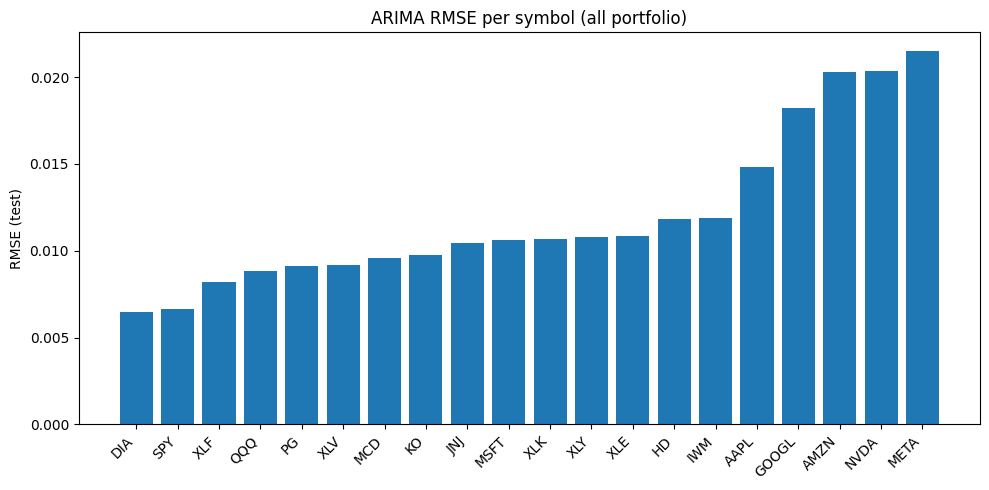

In [16]:
plt.figure(figsize=(10, 5))
plt.bar(results_df["symbol"], results_df["rmse"])
plt.xticks(rotation=45, ha="right")
plt.ylabel("RMSE (test)")
plt.title(f"ARIMA RMSE per symbol ({PORTFOLIO_NAME} portfolio)")
plt.tight_layout()
plt.show()
